
# Testing a Potential Moderator

In [1]:

import pickle
import pandas as pd

# Handy list of the different types of encodings
encoding = ['latin1', 'iso8859-1', 'utf-8'][1]

# Change this to your data and saves folders
data_folder = r'../../data/'
saves_folder = r'../../saves/'

def load_object(obj_name):
    pickle_path = saves_folder + 'pickle/' + obj_name + '.pickle'
    try:
        object = pd.read_pickle(pickle_path)
    except:
        with open(pickle_path, 'rb') as handle:
            object = pickle.load(handle)
    
    return(object)

In [2]:

from sklearn.decomposition import PCA
import os

obj_path = saves_folder + 'pickle/gapminder_df.pickle'
if not os.path.isfile(obj_path):
    gapminder_df = pd.read_csv(data_folder + 'csv/gapminder.csv',
                               low_memory=False, encoding=encoding)
else:
    gapminder_df = load_object('gapminder_df')
gapminder_df.columns = ['country_name', 'income_per_person',
                        'alcohol_consumption', 'armed_forces_rate',
                        'breast_cancer_per_100th', 'co2_emissions',
                        'female_employment_rate', 'hiv_rate',
                        'internet_use_rate', 'life_expectancy',
                        'oil_per_person', 'polity_score',
                        'residential_electricity_per_person',
                        'suicide_per_100th', 'employment_rate',
                        'urban_rate']
number_column_list = list(set(gapminder_df.columns) - set(['country_name']))
elite_df = gapminder_df.dropna(how='any').copy()
elite_ndarray = PCA(n_components=2).fit_transform(elite_df[number_column_list])

In [3]:

# Classes, functions, and methods cannot be pickled
def store_objects(**kwargs):
    for obj_name in kwargs:
        if hasattr(kwargs[obj_name], '__call__'):
            raise RuntimeError('Functions cannot be pickled.')
        obj_path = saves_folder + 'pickle/' + str(obj_name)
        pickle_path = obj_path + '.pickle'
        if isinstance(kwargs[obj_name], pd.DataFrame):
            kwargs[obj_name].to_pickle(pickle_path)
        else:
            with open(pickle_path, 'wb') as handle:
                pickle.dump(kwargs[obj_name], handle, pickle.HIGHEST_PROTOCOL)

In [4]:

obj_path = saves_folder + 'pickle/formal_name_dict.pickle'
if not os.path.isfile(obj_path):
    formal_name_dict = {}
    formal_name_dict['alcohol_consumption'] = '2008 alcohol consumption per adult (age 15+) in litres'
    formal_name_dict['armed_forces_rate'] = 'Armed forces personnel as a % of total labor force'
    formal_name_dict['breast_cancer_per_100th'] = '2002 breast cancer new cases per hundred thousand females'
    formal_name_dict['co2_emissions'] = '2006 cumulative CO2 emission in metric tons'
    formal_name_dict['employment_rate'] = '2007 total employees age 15+ as a % of population'
    formal_name_dict['female_employment_rate'] = '2007 female employees age 15+ as a % of population'
    formal_name_dict['hiv_rate'] = '2009 estimated HIV Prevalence % for Ages 15-49'
    formal_name_dict['income_per_person'] = '2010 Gross Domestic Product per capita in constant 2000 USD'
    formal_name_dict['internet_use_rate'] = '2010 Internet users per 100 people'
    formal_name_dict['life_expectancy'] = '2011 life expectancy at birth in years'
    formal_name_dict['oil_per_person'] = '2010 oil Consumption per capita in tonnes per year and person'
    formal_name_dict['polity_score'] = '2009 Democracy score as measured by Polity'
    formal_name_dict['residential_electricity_per_person'] = '2008 residential electricity consumption per person in kWh'
    formal_name_dict['suicide_per_100th'] = '2005 Suicide age adjusted per hundred thousand'
    formal_name_dict['urban_rate'] = '2008 urban population as a % of total'
    store_objects(formal_name_dict=formal_name_dict)
else:
    formal_name_dict = load_object('formal_name_dict')

In [5]:

obj_path = saves_folder + 'pickle/informal_name_dict.pickle'
if not os.path.isfile(obj_path):
    informal_name_dict = {}
    informal_name_dict['alcohol_consumption'] = 'alcohol consumption'
    informal_name_dict['armed_forces_rate'] = 'armed forces rate'
    informal_name_dict['breast_cancer_per_100th'] = 'breast cancer'
    informal_name_dict['co2_emissions'] = 'CO2 emissions'
    informal_name_dict['employment_rate'] = 'employment rate'
    informal_name_dict['female_employment_rate'] = 'female employment rate'
    informal_name_dict['hiv_rate'] = 'HIV rate'
    informal_name_dict['income_per_person'] = 'income per person'
    informal_name_dict['internet_use_rate'] = 'internet use rate'
    informal_name_dict['life_expectancy'] = 'life expectancy'
    informal_name_dict['oil_per_person'] = 'oil per person'
    informal_name_dict['polity_score'] = 'polity score'
    informal_name_dict['residential_electricity_per_person'] = 'residential electricity'
    informal_name_dict['suicide_per_100th'] = 'suicide rate'
    informal_name_dict['urban_rate'] = 'urban rate'
    store_objects(informal_name_dict=informal_name_dict)
else:
    informal_name_dict = load_object('informal_name_dict')

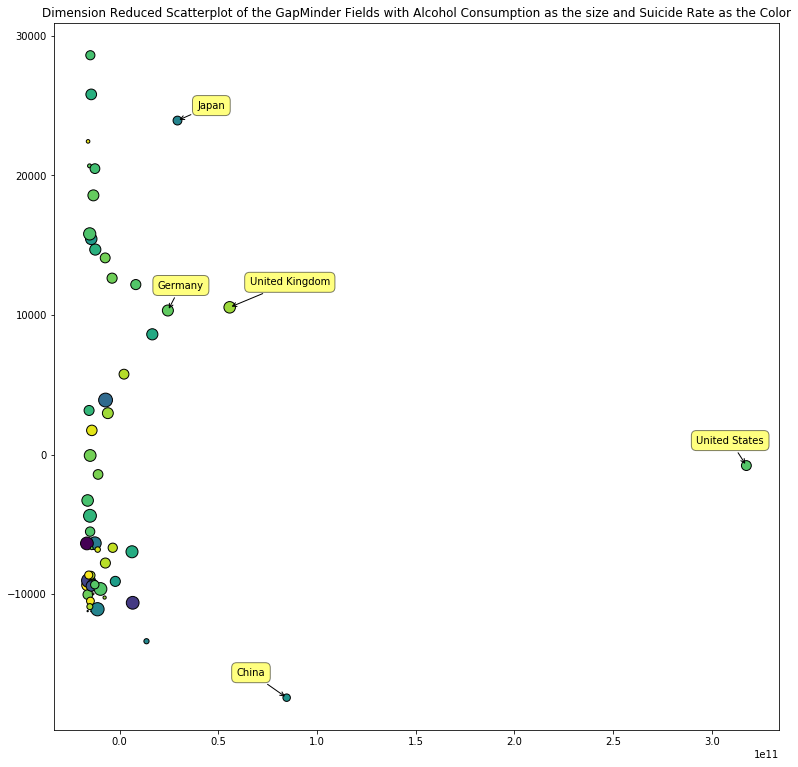

In [6]:

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=7750000000, min_samples=2).fit(elite_ndarray)
labels = db.labels_

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, autoscale_on=True)
cmap = plt.get_cmap('viridis_r')
path_collection = ax.scatter(elite_ndarray[:, 0], elite_ndarray[:, 1],
                             s=elite_df['alcohol_consumption']*10,
                             c=elite_df['suicide_per_100th'],
                             edgecolors=(0, 0, 0), cmap=cmap)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
for col, label, x, y in zip(labels, elite_df['country_name'],
                            elite_ndarray[:, 0], elite_ndarray[:, 1]):
    if (label == 'Japan'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 10), **kwargs)
    elif (label == 'United Kingdom'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 20), **kwargs)
    elif (label == 'China') or (label == 'United States'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-50, 20), **kwargs)
    elif (col == 1):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-10, 20), **kwargs)
title_text = 'Dimension Reduced Scatterplot of the GapMinder '
title_text += 'Fields with Alcohol Consumption as the size and '
title_text += 'Suicide Rate as the Color'
text = plt.title(title_text)

In [7]:

def create_binned_categories(df, number_of_categories, column_name, prefix):
    
    # Get the percentiles
    out_categorical, percentiles_list = pd.cut([0, 1], number_of_categories, retbins=True)
    describe_series = df[column_name].describe(percentiles=percentiles_list[1:-1]).copy()

    # Get the bin list and group names
    bad_list = ['count', 'mean', 'std']
    if (number_of_categories % 2) == 1:
        bad_list += ['50%']
    index_list = [x for x in describe_series.index.tolist() if x not in bad_list]
    bin_list = describe_series.loc[index_list].tolist()

    # Create the extra column
    df[prefix+'_categories'] = pd.cut(df[column_name],
                                      bin_list).map(lambda x: (x.left + x.right)/2.)

    # Fix the bottom row
    null_series = df[prefix+'_categories'].isnull()
    df.loc[null_series, prefix+'_categories'] = df[~null_series][prefix+'_categories'].min()

    return df

In [8]:

from scipy.stats import pearsonr

class Statements(object):

    def __init__(self, df, qe_column, qr_column, md_column, **kwargs):
        prop_defaults = {
            'low_high': 'both',
            'explanation_list': ['Pearson’s correlation coefficient', '2-tailed p-value'],
            'verbose_html': '',
            'qe_formal_name': formal_name_dict[qe_column],
            'qr_formal_name': formal_name_dict[qr_column],
            'md_formal_name': formal_name_dict[md_column],
            'qe_informal_name': informal_name_dict[qe_column],
            'qr_informal_name': informal_name_dict[qr_column],
            'md_informal_name': informal_name_dict[md_column],
        }

        for (prop, default) in prop_defaults.items():
            setattr(self, prop, kwargs.get(prop, default))
        
        self.df = df
        self.qe_column = qe_column
        self.qr_column = qr_column
        self.md_column = md_column
        self.df = self.df.dropna(how='any', subset=[self.qe_column, self.qr_column, self.md_column]).copy()
        
        self.pearsonr_tuple = pearsonr(self.df[qe_column], self.df[qr_column])
        self.pearson_r = self.pearsonr_tuple[0]
        self.coefficient_of_determination = self.pearson_r**2
        self.percent_predictable = self.coefficient_of_determination*100
        self.p_value = self.pearsonr_tuple[1]
        if 'md_categories' in self.df.columns:
            if self.low_high == 'both':
                self.moderator_statement = ('categories ' +
                                            ' and '.join(self.df['md_categories'].unique().map(lambda x: str('%.2f' % x))))
            else:
                self.moderator_statement = 'category ' + str('%.2f' % self.df['md_categories'].unique().tolist()[0])
        if self.pearson_r > 0:
            self.adjective_positive = 'positive'
        else:
            self.adjective_positive = 'negative'
        self.pearsonr_statement = str('%.2f' % self.pearson_r)
        if self.coefficient_of_determination >= 0.25:
            self.adverb_strong = 'strongly'
        else:
            self.adverb_strong = 'weakly'
        self.cod_statement = str('%.2f' % self.coefficient_of_determination)
        self.percent_statement = str('%.1f' % self.percent_predictable)
        if self.p_value < 0.0001:
            self.pvalue_statement = '<0.0001'
        else:
            self.pvalue_statement = '=' + str('%.4f' % self.p_value)
        if self.p_value < 0.05:
            self.adverb_significant = 'significantly'
        else:
            self.adverb_significant = 'insignificantly'

In [9]:

from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import squareform, pdist, euclidean
import numpy as np

# From https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def round_down(num, divisor):
    
    return num - (num%divisor)

def round_up(num, divisor):
    
    return num - (num%divisor) + divisor

def get_min_max(df, column_name, circle_min=5, circle_max=500):
    min_max_scaler = MinMaxScaler(feature_range=(circle_min, circle_max))
    min_max = min_max_scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    
    return min_max

In [10]:

def set_up_a_minimal_joint_grid(sts):
    scatter_kws = dict(s=0, edgecolors='w')
    joint_kws = dict(scatter_kws=scatter_kws)
    xlim_multiple = round_up((sts.df[sts.qe_column].max() - sts.df[sts.qe_column].min()) / 10, 10)
    xlim = (round_down(sts.df[sts.qe_column].min(), xlim_multiple), round_up(sts.df[sts.qe_column].max(), xlim_multiple))
    ylim_multiple = round_up((sts.df[sts.qr_column].max() - sts.df[sts.qr_column].min()) / 10, 10)
    ylim = (round_down(sts.df[sts.qr_column].min(), ylim_multiple), round_up(sts.df[sts.qr_column].max(), ylim_multiple))
    sts.joint_grid = sns.jointplot(x=sts.qe_column, y=sts.qr_column, data=sts.df, size=13, space=0,
                               stat_func=None, kind='reg',
                               joint_kws=joint_kws, marginal_kws=dict(bins=15, rug=True))
    
    return sts

In [11]:

def get_correct_scale(sts):
    sts.joint_grid.ax_joint.set_autoscale_on(b=True)
    sts.joint_grid.ax_marg_x.set_autoscale_on(b=True)
    sts.joint_grid.ax_marg_y.set_autoscale_on(b=True)
    
    sts.ax_joint_xlim = sts.joint_grid.ax_joint.get_xlim()
    sts.ax_joint_ylim = sts.joint_grid.ax_joint.get_ylim()
    
    sts.ax_marg_x_xlim = sts.joint_grid.ax_marg_x.get_xlim()
    sts.ax_marg_x_ylim = sts.joint_grid.ax_marg_x.get_ylim()
    
    sts.ax_marg_y_xlim = sts.joint_grid.ax_marg_y.get_xlim()
    sts.ax_marg_y_ylim = sts.joint_grid.ax_marg_y.get_ylim()
    
    return sts

In [12]:

def set_the_axes_and_title_text(sts):
    xlabel = sts.qe_formal_name + ' (Explanatory Variable)'
    ylabel = sts.qr_formal_name + ' (Response Variable)'
    sts.joint_grid.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    plot_title_text = ('Scatterplot for the association between ' +
                       sts.qe_informal_name + ' and ' +
                       sts.qr_informal_name + ', colored and sized with ' +
                       sts.md_informal_name)
    sts.joint_grid.fig.suptitle(plot_title_text)
    
    return sts

In [13]:

def re_color_and_resize_the_plot_points(sts):
    cmap = plt.get_cmap('viridis_r')
    scatter_kws = dict(s=get_min_max(sts.df, sts.md_column), edgecolors=(0, 0, 0),
                       cmap=cmap, color=None, c=sts.df[sts.md_column])
    sts.joint_grid = sts.joint_grid.plot_joint(sns.regplot, fit_reg=False, scatter_kws=scatter_kws)
    
    return sts

In [14]:

def force_correct_scale(sts):
    sts.joint_grid.ax_joint.set_autoscale_on(b=True)
    sts.joint_grid.ax_marg_x.set_autoscale_on(b=True)
    sts.joint_grid.ax_marg_y.set_autoscale_on(b=True)
    
    sts.joint_grid.ax_joint.set_xlim(sts.ax_joint_xlim)
    sts.joint_grid.ax_marg_x.set_xlim(sts.ax_marg_x_xlim)
    sts.joint_grid.ax_marg_y.set_xlim(sts.ax_marg_y_xlim)
    
    sts.joint_grid.ax_joint.set_ylim(sts.ax_joint_ylim)
    sts.joint_grid.ax_marg_x.set_ylim(sts.ax_marg_x_ylim)
    sts.joint_grid.ax_marg_y.set_ylim(sts.ax_marg_y_ylim)
    
    return sts

In [15]:

def set_the_upper_left_math(sts):
    r_squared = lambda a, b: pearsonr(a, b)[0] ** 2
    sts.joint_grid = sts.joint_grid.annotate(r_squared, template='{stat}: {val:.2f}', stat='$R^2$',
                                     loc='upper left', fontsize=18, bbox_to_anchor=(-0.07, 1.0),
                                     frameon=False)
    
    return sts

In [16]:

def set_the_country_name_labels(sts):
    kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Get the center of the plot points
    column_pair = [sts.qe_column, sts.qr_column]
    center_series = sts.df[column_pair].apply(lambda col: col.mean(), axis=0)
    center_matrix = center_series.as_matrix()
    center_x = center_matrix[0]
    center_y = center_matrix[1]
    sts.df['dist_from_center'] = sts.df.apply(lambda row: euclidean(center_matrix, row[column_pair].as_matrix()), axis=1)
    sts.df['angle_from_center'] = sts.df.apply(lambda row: angle_between(center_matrix, row[column_pair].as_matrix()), axis=1)
    
    # Annotate those countries far from the center
    angle_list = []
    dist_list = []
    precision_level = 3
    for row_index, row_series in sts.df.sort_values('dist_from_center', ascending=False).head(17).iterrows():
        row_x = row_series[sts.qe_column]
        row_y = row_series[sts.qr_column]
        row_angle = row_series['angle_from_center']
        row_dist = row_series['dist_from_center']
        if round(row_angle, precision_level) not in angle_list:
            angle_list.append(round(row_angle, precision_level))
            #annotation = sts.joint_grid.ax_joint.annotate(row_series['country_name'], xy=(row_x, row_y), xytext=(-10, 20), **kwargs)
            annotation = sts.joint_grid.ax_joint.annotate(row_series['country_name'], xy=(row_x, row_y),
                                                      xytext=(20*n for n in np.sign([row_x-center_x, row_y-center_y])), **kwargs)
    
    return sts

In [17]:

%matplotlib inline
import seaborn as sns
from IPython.display import Image

def add_joint_plot(sts):

    # Turn interactive plotting off
    plt.ioff()
    
    # Set up a minimal joint grid
    print()
    sts = set_up_a_minimal_joint_grid(sts)
    
    # Get correct scale
    sts = get_correct_scale(sts)

    # Set the axes and title text
    sts = set_the_axes_and_title_text(sts)

    # Re-color and resize the plot points
    sts = re_color_and_resize_the_plot_points(sts)
    
    # Force correct scale
    sts = force_correct_scale(sts)

    # Set the upper left math
    sts = set_the_upper_left_math(sts)
    
    # Force correct scale
    sts = force_correct_scale(sts)
    
    # Set the country name labels
    sts = set_the_country_name_labels(sts)
    
    # Save the new figure then close it so it never gets displayed
    file_name = ('../../saves/png/plot_' + sts.qe_column + '_' + sts.qr_column +
                 '_' + sts.md_column + '_' + sts.low_high + '.png')
    sts.joint_grid.savefig(file_name)
    plt.close(sts.joint_grid.fig)
    
    #sts.verbose_html += '<p><image src="' + file_name + '" /></p>'
    
    # Display all "open" (non-closed) figures
    plt.show()

    return Image(filename=file_name, width=1000)

In [18]:

from IPython.display import HTML

# Pearson’s Correlation Coefficient
def model_interpretation(sts, sample_name='the population', verbose=False):
        
    if verbose:
        sts.verbose_html += ('<p>Association between ' + 
                         sts.qe_informal_name + ' and ' + 
                         sts.qr_informal_name + ', with ' + 
                         sts.md_informal_name + ' moderator ' +
                         sts.moderator_statement + '<ul>')
        for x, y in zip(sts.explanation_list, sts.pearsonr_tuple):
            sts.verbose_html += '<li>{}: {}</li>'.format(x, y)
        sts.verbose_html += '</ul></p>'
        
    if sts.low_high == 'both':
        pearsonr_html = ('<h3>Model Interpretation for Pearson’s Correlation Coefficient Tests, Testing a Potential Moderator:</h3>' +
                         '<p>The Pearson’s Correlation Coefficient revealed that among ')
    else:
        pearsonr_html = ('<p>The Pearson’s Correlation Coefficient exclusive to the ' +
                         sts.low_high + ' ' +
                         sts.moderator_statement + ' of the ' +
                         sts.md_informal_name + ' moderator revealed that among ')
    pearsonr_html += (sample_name + ', ' +
                      sts.qe_formal_name + ' (quantitative explanatory variable), and ' +
                      sts.qr_formal_name + ' (quantitative response variable) were ' +
                      sts.adverb_significant + ' associated, in a ' +
                      sts.adverb_strong + ' ' +
                      sts.adjective_positive + r' manner, $r=' +
                      sts.pearsonr_statement + ', p' +
                      sts.pvalue_statement + r'$. This means that if we know the ' +
                      sts.qe_informal_name + ' of ' +
                      sts.low_high + ' ' +
                      sts.md_informal_name + ' ' +
                      sts.moderator_statement + ', we can predict ' +
                      sts.percent_statement + '% of the ' +
                      sts.qr_informal_name + '.</p>')
    
    if verbose:
        join_plot_Image = add_joint_plot(sts)
    else:
        
        # From http://www.1x1px.me/
        file_path = '../../data/png/FFFFFF-0.0.png'
        join_plot_Image = Image(data=file_path)
    
    return HTML(pearsonr_html + sts.verbose_html), join_plot_Image

In [19]:

# A response variable corresponds to a dependent variable while
# an explanatory variable corresponds to an independent variable
def moderator_conclusion(both_sts, low_sts, high_sts):
    if high_sts.coefficient_of_determination > both_sts.coefficient_of_determination:
        verb_high_increased = 'increased'
    elif high_sts.coefficient_of_determination < both_sts.coefficient_of_determination:
        verb_high_increased = 'decreased'
    else:
        verb_high_increased = 'stayed the same'
    if low_sts.coefficient_of_determination > both_sts.coefficient_of_determination:
        verb_low_increased = 'increased'
    elif low_sts.coefficient_of_determination < both_sts.coefficient_of_determination:
        verb_low_increased = 'decreased'
    else:
        verb_low_increased = 'stayed the same'
    summary_html = ('<h3>Summary</h3><p>The effect of the moderating (' +
                    both_sts.md_informal_name + ') variable is characterized ' +
                    'statistically as an interaction; that is, a categorical (in this case low or high) ' +
                    'variable that affects the strength of the relation between the dependent (' +
                    both_sts.qr_informal_name + ') and the independent (' +
                    both_sts.qe_informal_name + ') variable. In our study, the strength of the relation ' +
                    '(coefficient of determination) between ' +
                    both_sts.qr_informal_name + ' and ' +
                    both_sts.qe_informal_name + ', when considering only the high ' +
                    high_sts.moderator_statement + ' of ' +
                    high_sts.md_informal_name + ', ' +
                    verb_high_increased + ' from ' +
                    both_sts.cod_statement + ' to ' +
                    high_sts.cod_statement + '. Similarly, when considering only the low ' +
                    low_sts.moderator_statement + ' of ' +
                    low_sts.md_informal_name + ', the strength of the relation ' +
                    verb_low_increased + ' from ' +
                    both_sts.cod_statement + ' to ' +
                    low_sts.cod_statement + '.')
    
    return HTML(summary_html)

In [20]:

def pearsons_with_moderator(sts, source_name='GapMinder.org', verbose=False):
    
    
    both_df = create_binned_categories(sts.df, 2, sts.md_column,'md')
    both_sts = Statements(both_df, sts.qe_column, sts.qr_column, sts.md_column)
    sample_name = 'the sample of ' + str(both_df.shape[0]) + ' countries from ' + source_name
    model_interpretation_HTML, join_plot_Image = model_interpretation(both_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(join_plot_Image)
    
    match_series = (both_df['md_categories'] == both_df['md_categories'].min())
    low_df = both_df[match_series].copy()
    low_sts = Statements(low_df, sts.qe_column, sts.qr_column, sts.md_column, low_high='low')
    sample_name = 'the sample of ' + str(low_df.shape[0]) + ' low category countries from ' + source_name
    model_interpretation_HTML, join_plot_Image = model_interpretation(low_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(join_plot_Image)
    
    match_series = (both_df['md_categories'] == both_df['md_categories'].max())
    high_df = both_df[match_series].copy()
    high_sts = Statements(high_df, sts.qe_column, sts.qr_column, sts.md_column, low_high='high')
    sample_name = 'the sample of ' + str(high_df.shape[0]) + ' high category countries from ' + source_name
    model_interpretation_HTML, join_plot_Image = model_interpretation(high_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(join_plot_Image)
    
    display(moderator_conclusion(both_sts, low_sts, high_sts))


# Choose two features with a high r squared and low/high contrast

In [21]:

# Choose two features with a high r squared
rows_list = []
column_set_list = []
for qe_column in number_column_list:
    for qr_column in number_column_list:
        if qe_column is not qr_column:
            column_set = set([qe_column, qr_column])
            if column_set not in column_set_list:
                column_set_list.append(column_set)
                row_dict = {}
                df = gapminder_df.dropna(how='any', subset=[qe_column, qr_column]).copy()
                coefficient_of_determination = pearsonr(df[qe_column], df[qr_column])[0]**2
                row_dict['qe_column'] = qe_column
                row_dict['qr_column'] = qr_column
                row_dict['coefficient_of_determination'] = coefficient_of_determination
                rows_list.append(row_dict)
determinations_df = pd.DataFrame(rows_list, columns=['qe_column', 'qr_column', 'coefficient_of_determination'])
determinations_df.sort_values('coefficient_of_determination', ascending=False).head(10)

,qe_column,qr_column,coefficient_of_determination
37,employment_rate,female_employment_rate,0.735306
50,breast_cancer_per_100th,internet_use_rate,0.621603
64,internet_use_rate,life_expectancy,0.583573
4,income_per_person,internet_use_rate,0.563910
3,income_per_person,breast_cancer_per_100th,0.534944
10,income_per_person,residential_electricity_per_person,0.424631
55,breast_cancer_per_100th,life_expectancy,0.406154
66,internet_use_rate,urban_rate,0.376930
96,life_expectancy,urban_rate,0.374080
9,income_per_person,life_expectancy,0.361822


In [22]:

sts = Statements(gapminder_df,
                 'residential_electricity_per_person', 'breast_cancer_per_100th', 'female_employment_rate')
pearsons_with_moderator(sts, verbose=False)

In [23]:

# Choose three features with a large low/high contrast
rows_list = []
column_set_list = []
for qe_column in number_column_list:
    for qr_column in number_column_list:
        for md_column in number_column_list:
            moderation_columns_list = [qe_column, qr_column, md_column]
            moderation_column_set = set(moderation_columns_list)
            if len(moderation_columns_list) == len(moderation_column_set):
                if moderation_column_set not in column_set_list:
                    column_set_list.append(moderation_column_set)
                    row_dict = {}
                    both_df = create_binned_categories(gapminder_df.dropna(how='any',
                                                                           subset=[qe_column, qr_column, md_column]).copy(),
                                                       2, md_column,'md')
                    match_series = (both_df['md_categories'] == both_df['md_categories'].min())
                    low_df = both_df[match_series].copy()
                    low_cod = pearsonr(low_df[qe_column], low_df[qr_column])[0]**2

                    match_series = (both_df['md_categories'] == both_df['md_categories'].max())
                    high_df = both_df[match_series].copy()
                    high_cod = pearsonr(high_df[qe_column], high_df[qr_column])[0]**2
                    
                    row_dict['qe_column'] = qe_column
                    row_dict['qr_column'] = qr_column
                    row_dict['md_column'] = md_column
                    row_dict['cod_diff'] = abs(high_cod - low_cod)
                    rows_list.append(row_dict)
moderations_df = pd.DataFrame(rows_list, columns=['qe_column', 'qr_column', 'md_column', 'cod_diff'])
moderations_df.sort_values('cod_diff', ascending=False).head(10)

,qe_column,qr_column,md_column,cod_diff
394,oil_per_person,residential_electricity_per_person,female_employment_rate,0.697064
330,breast_cancer_per_100th,residential_electricity_per_person,female_employment_rate,0.605936
329,breast_cancer_per_100th,residential_electricity_per_person,urban_rate,0.568953
1,income_per_person,co2_emissions,hiv_rate,0.568438
373,oil_per_person,armed_forces_rate,life_expectancy,0.565745
299,breast_cancer_per_100th,oil_per_person,armed_forces_rate,0.559284
393,oil_per_person,residential_electricity_per_person,urban_rate,0.546052
44,income_per_person,breast_cancer_per_100th,female_employment_rate,0.531336
374,oil_per_person,armed_forces_rate,residential_electricity_per_person,0.517914
45,income_per_person,breast_cancer_per_100th,polity_score,0.509961


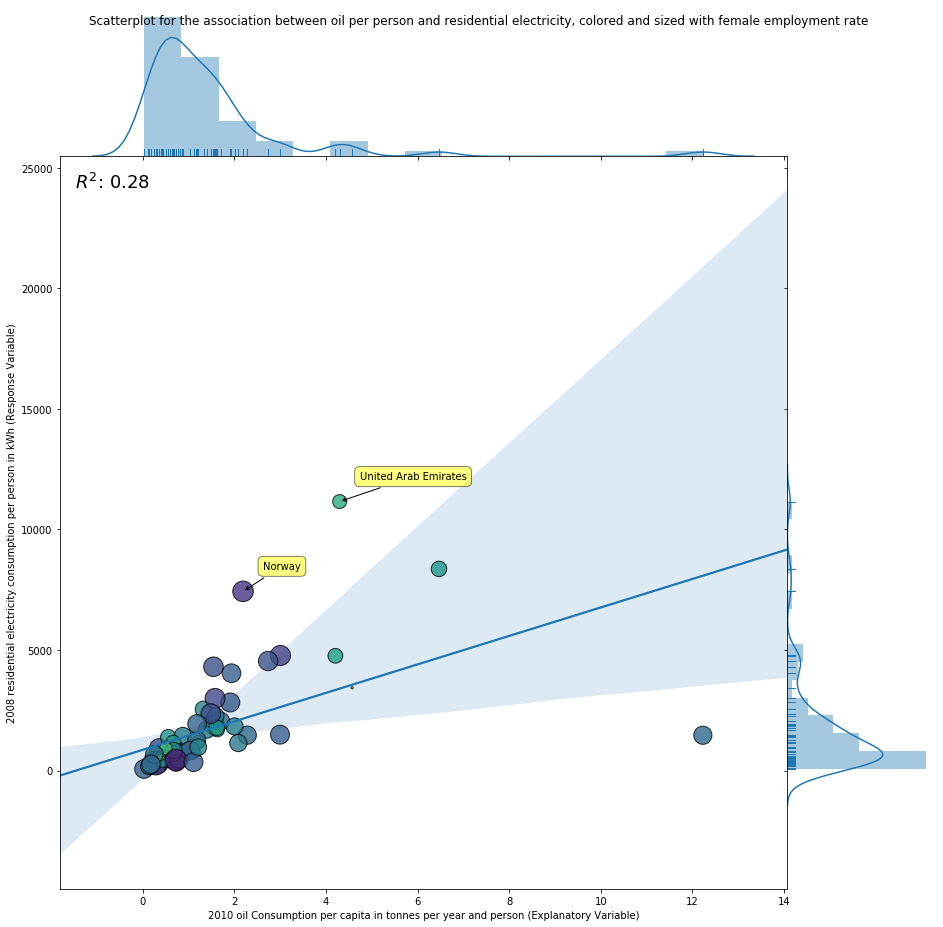

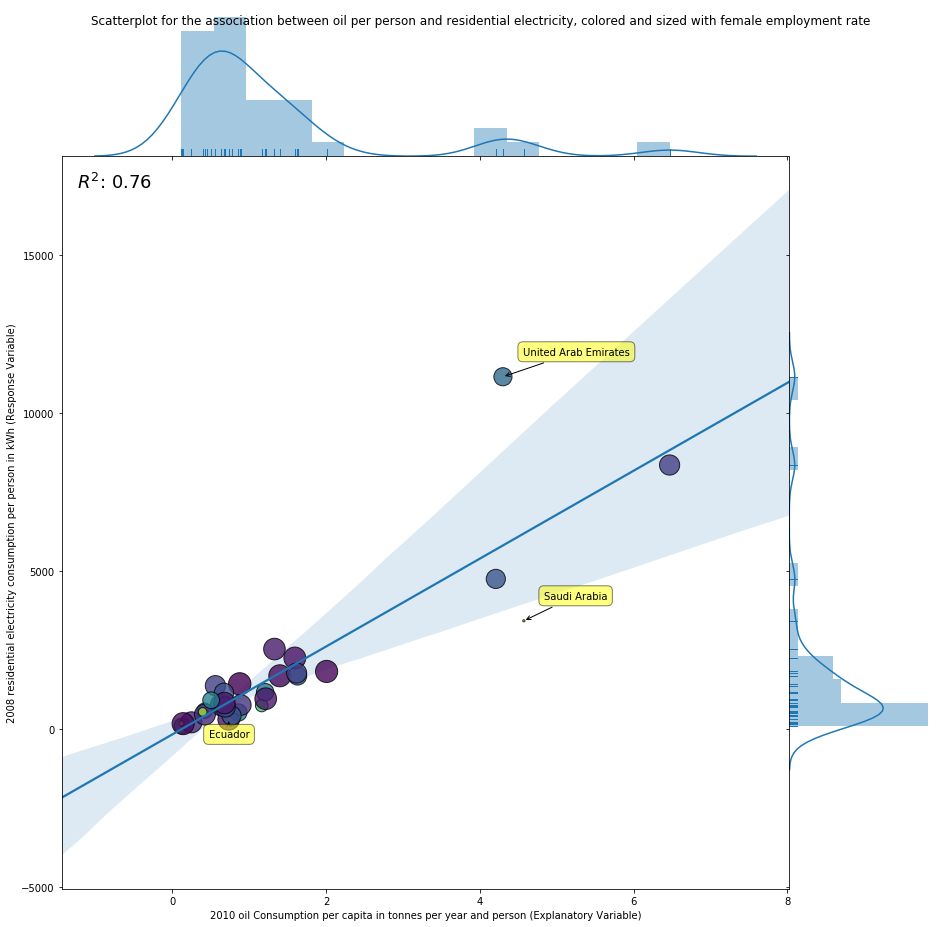

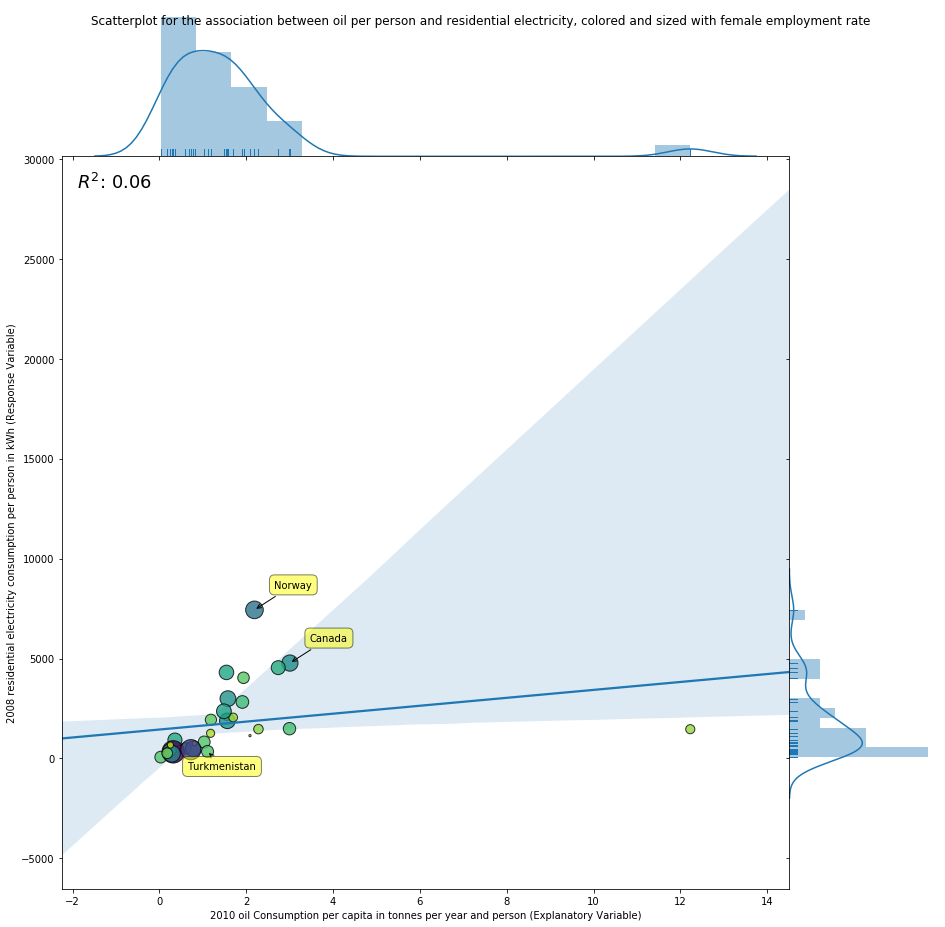

In [24]:

sts = Statements(gapminder_df,
                 *moderations_df.sort_values('cod_diff', ascending=False).head().values.tolist()[0][:-1])
pearsons_with_moderator(sts, verbose=True)

In [25]:

%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "notebook_path = " + "'"+attribs['data-notebook-path'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [26]:
# %load ../../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/' + notebook_path
HTML('Click <a href="' + notebook_viewer_url + '" target="_blank">here</a> to view notebook in nbviewer.')